# Computing and visualization of linear trends during the observed period (1980-2014) for precipitation

We present and illustrative example to to use the Atlas hub and the climate4R framework that depicts the observed linear trends and the anomalies time series of precipitation over North America (indications for temperature are also available), over a selected time period for the Daymet version 3 observational dataset. 

We build on the climate4R framework, a set of R libraries especifically developed for the tasks of loading, processing and manipulation of climate data. For more information regarding this framework and its installation, we refer the reader to the GitHub repository that provides all the information necessary.

In [1]:
options(java.parameters = "-Xmx8g")
library(loadeR) # C4R
library(transformeR) # C4R
library(visualizeR) # C4R
library(geoprocessoR) # C4R
# library(climate4R.value) # C4R


library(magrittr) # The package magrittr is used to pipe (%>%) sequences of data operations improving readability
library(gridExtra) # plotting functionalities
library(sp) # plotting functionalities
library(RColorBrewer)  # plotting functionalities e.g., color palettes
library(rgdal)

Loading required package: rJava

Loading required package: loadeR.java

Java version 1.8x amd64 by JetBrains s.r.o detected

NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready

Loading required package: climate4R.UDG

climate4R.UDG version 0.2.0 (2020-07-31) is loaded

Please use 'citation("climate4R.UDG")' to cite this package.

loadeR version 1.7.0 (2020-09-18) is loaded

Please use 'citation("loadeR")' to cite this package.




    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.0.2 (2020-09-02) is loaded


Development version may have an unexpected behaviour

Please see 'citation("transformeR")' to cite this package.

Warning message:
“no DISPLAY variable so Tk is not available”
visualizeR version 1.6.0 (2020-05-23) is loaded

Please see 'citation("visualizeR")' to cite this package.

geoprocessoR version 0.2.0 (2020-01-06) is loaded

Please see 'citation("geoprocessoR")' to cite this package.

rgdal: version: 1.5-16, (SVN revision 1050)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.0.1, released 2019/06/28
Path to GDAL shared files: /opt/conda/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 6.1.1, July 1st, 2019, [PJ_VERSION: 611]
Path to PROJ shared files: /opt/conda/share/proj
Linking to sp version:1.4-2
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading rgdal.



We load the IPCC regions (see [reference paper](https://essd.copernicus.org/articles/12/2959/2020/essd-12-2959-2020.html)), that can be found as an `.rda` file in the [ATLAS GitHub reository](https://github.com/SantanderMetGroup/ATLAS/tree/master/reference-regions).

In [2]:
# We load the coast, to be used in the below spatial maps. Note that all the WORLD_coastline files located in 
# https://github.com/SantanderMetGroup/ATLAS/tree/master/man
# have to be downloaded to your working directory
coast <- readOGR("WORLD_coastline.shp") 
# We use the `url` function to access the data directly from the ATLAS GitHub repository
regs <- get(load(url("https://raw.githubusercontent.com/SantanderMetGroup/ATLAS/master/reference-regions/IPCC-WGI-reference-regions-v4_R.rda")))
regs <- as(regs, "SpatialPolygons")
regs.area <- c("NWN", "NEN", "WNA", "CNA","ENA","NCA","SCA","CAR") # North America regions

Warning message in ogrInfo(dsn = dsn, layer = layer, encoding = encoding, use_iconv = use_iconv, :
“ogrInfo: /home/jovyan/work/Atlas_Observations/WORLD_coastline.dbf not found”


OGR data source with driver: ESRI Shapefile 
Source: "/home/jovyan/work/Atlas_Observations/WORLD_coastline.shp", layer: "WORLD_coastline"
with 127 features
It has 0 fields


### Parameters defined by the user
The user can tune these parameters to define characteristics of the data (e.g., domain boundaries, temporal period)

In [28]:
# Parameters for downloading data
var <- "pr" # Variable names; type C4R.vocabulary() for name coding
latLim <- c(12,74) # Latitude boundaries
lonLim <- c(-170,-50) # Longitude boundaries
years <- 1980:2014 # temporal period
temporalAggregationFunction <- "mean" # How shall we aggregate daily data to a yearly resolution? Consider changing to "mean" if var = "tas" (temperature)

# Parameters for plotting figures
colorScale_climatology <- seq(0, 10, 1)
colorScale_trends <- seq(-0.1, 0.1, 0.01)
ylim_anom <- c(-1,1)

### Load data stored in the Atlas hub
To load data stored in the Atlas hub (similar to loading data from a local directory), we rely on the C4R library called `climate4R.hub`, that contains 2 main functions: `HUB.datasets` and `loadHubData`.

*** NOTE: We should be working on the Atlas hub for these chunks of code to work. ***

On the one hand, `HUB.datasets` lists all the datasets accessible from the Atlas Hub.

In [4]:
# devtools::install_github("SantanderMetGroup/climate4R.hub") # Uncomment this line to install climate4R.hub
library(climate4R.hub)
HUB.datasets()

climate4R.hub version 0.0.0 (2020-12-03) is loaded

Please use 'citation("climate4R.hub")' to cite this package.

Warning this package is only to work in the Atlas hub

Label names are returned, set argument full.info = TRUE to get more information



$OBSERVATIONS
[1] "E-OBS_v21e_0.10regular" "E-OBS_v21e_0.25regular" "Daymet_v3_0.25regular"

We see how, to-date, only Daymet and E-OBS datasets are available from the Atlas Hub (more coming). For example, to load Daymet we just input the Daymet label to the `dataset` argument in `loadHubData` (which contains the same arguments than `loadGridData`)

In [5]:
# takes around 20-25 mins...
grid <- lapply(years, FUN = function(zz){
    aux <- loadHubData(dataset = "Daymet_v3_0.25regular",
                        var = var, # replace "pr" for "tas" to download surface temperature. Type C4R.vocabulary() for more information regarding the code of the variables
                        latLim = latLim,
                        lonLim = lonLim,
                        years = zz) %>% aggregateGrid(aggr.y = list(FUN = temporalAggregationFunction, na.rm = TRUE)) 
}) %>% bindGrid(dimension = "time")                                         
attr(grid$xyCoords, "projection") <- "+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0"  

[2020-12-10 18:42:09] Defining harmonization parameters for variable "pr"

[2020-12-10 18:42:10] Defining geo-location parameters

[2020-12-10 18:42:11] Defining time selection parameters

[2020-12-10 18:42:11] Retrieving data subset ...

[2020-12-10 18:42:22] Done

[2020-12-10 18:42:23] Performing annual aggregation...

[2020-12-10 18:42:40] Done.

[2020-12-10 18:42:40] Defining harmonization parameters for variable "pr"

[2020-12-10 18:42:40] Defining geo-location parameters

[2020-12-10 18:42:40] Defining time selection parameters

[2020-12-10 18:42:41] Retrieving data subset ...

[2020-12-10 18:42:51] Done

[2020-12-10 18:42:52] Performing annual aggregation...

[2020-12-10 18:43:09] Done.

[2020-12-10 18:43:09] Defining harmonization parameters for variable "pr"

[2020-12-10 18:43:09] Defining geo-location parameters

[2020-12-10 18:43:09] Defining time selection parameters

[2020-12-10 18:43:09] Retrieving data subset ...

[2020-12-10 18:43:19] Done

[2020-12-10 18:43:20] Perform

[2020-12-10 18:54:18] Defining time selection parameters

[2020-12-10 18:54:19] Retrieving data subset ...

[2020-12-10 18:54:33] Done

[2020-12-10 18:54:34] Performing annual aggregation...

[2020-12-10 18:54:51] Done.

[2020-12-10 18:54:51] Defining harmonization parameters for variable "pr"

[2020-12-10 18:54:51] Defining geo-location parameters

[2020-12-10 18:54:51] Defining time selection parameters

[2020-12-10 18:54:51] Retrieving data subset ...

[2020-12-10 18:55:05] Done

[2020-12-10 18:55:06] Performing annual aggregation...

[2020-12-10 18:55:23] Done.

[2020-12-10 18:55:23] Defining harmonization parameters for variable "pr"

[2020-12-10 18:55:23] Defining geo-location parameters

[2020-12-10 18:55:23] Defining time selection parameters

[2020-12-10 18:55:23] Retrieving data subset ...

[2020-12-10 18:55:37] Done

[2020-12-10 18:55:38] Performing annual aggregation...

[2020-12-10 18:55:56] Done.

[2020-12-10 18:55:56] Defining harmonization parameters for variable "pr"



### Working with loaded data

We define the geographical projection.

In [7]:
proj4string(regs) <- CRS(attr(grid$xyCoords,"projection"))

Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded datum WGS_1984 in CRS definition,
 but +towgs84= values preserved”
Warning message in proj4string(obj):
“CRS object has comment, which is lost in output”
Warning message in `proj4string<-`(`*tmp*`, value = new("CRS", projargs = "+proj=longlat +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +no_defs")):
“A new CRS was assigned to an object with an existing CRS:
+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0
without reprojecting.
For reprojection, use function spTransform”


We compute the climatology by calling the `climatology` function and then use `spatialPlot` from library `visualizeR` to depict it. We introduce the IPCC regions of interest in the `sp.layout` argument.

[2020-12-10 19:04:47] - Computing climatology...

[2020-12-10 19:04:49] - Done.



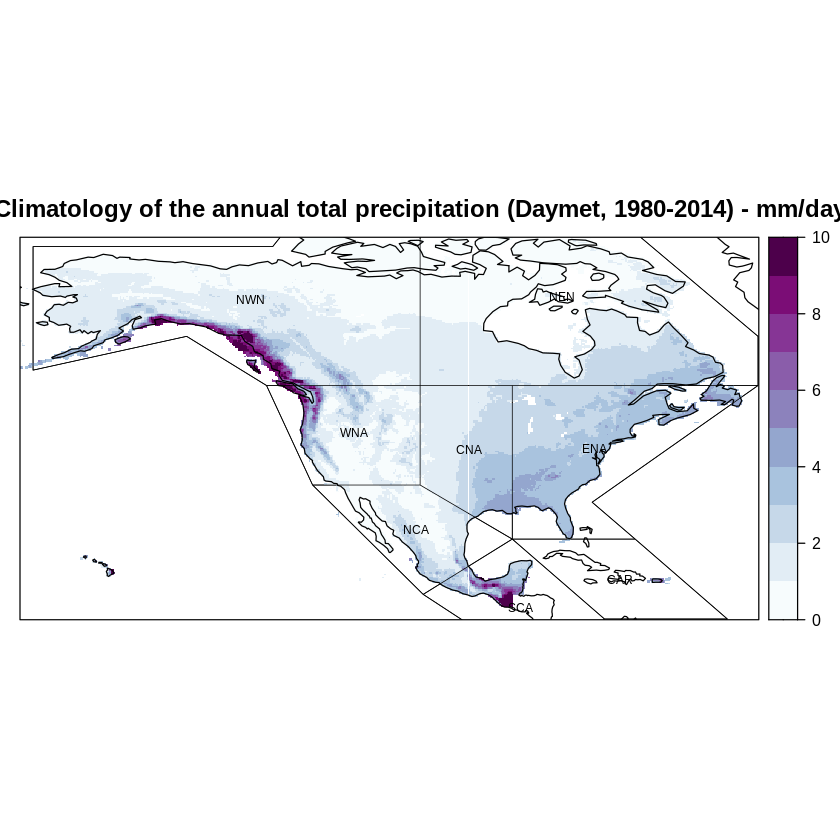

In [10]:
# pdf("climatology.pdf") ## Uncomment to save the figure
spatialPlot(climatology(grid),
            at = colorScale_climatology, 
            set.min = colorScale_climatology[1],
            set.max = colorScale_climatology[length(colorScale_climatology)],
            backdrop.theme = "coastline",
            col.regions = brewer.pal(n = 9, "BuPu") %>% colorRampPalette(),
            main = paste("Climatology of the annual total precipitation (Daymet, 1980-2014) - mm/day"),
            sp.layout = list(
                list(regs[regs.area], first = FALSE, lwd = 0.6),
                list("sp.text", coordinates(regs[regs.area]), names(regs[regs.area]), first = FALSE, cex = 0.6)
)) 
# dev.off() ## Uncomment to save the figure

We call the function `linearTrend` that computes the linear points at gridbox level and returns all the involved statistics (e.g., p-value of the estimated slope). We subset the slope ("b") among all the statistics returned, by calling `subsetGrid`. 

In [15]:
# devtools::install_github("SantanderMetGroup/climate4R.indices@devel") # Uncomment this line to upgrade climate4R.indices (10/12/2020)
library(climate4R.indices) # C4R

trendGrid <- linearTrend(grid, p = 0.9) %>% subsetGrid(var = "b")

The slope of the linear trend is estimated based on the temporal resolution of the data. Please consider using the function aggregateGrid prior to the call of linearTrend to adequate the data to your resolution of interest.

[2020-12-10 19:08:21] - Computing climatology...

[2020-12-10 19:08:22] - Done.

Warning message:
“Only one grid passed as input. Nothing was done”


We could save this climate products as NetCDF files using `loader.2nc` C4R library.

In [ ]:
# library(loadeR.2nc) # uncomment to save the trends as netCDF files
# grid2nc(trendGrid, NetCDFOutFile = "trends.nc4") # uncomment to save the trends as netCDF files

We call the function `overGrid` that overlaps the trends object with the IPCC regions located over NorthAmerica.

In [12]:
regsGrid <- overGrid(trendGrid, regs[regs.area])

Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded datum WGS_1984 in CRS definition,
 but +towgs84= values preserved”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded datum WGS_1984 in CRS definition,
 but +towgs84= values preserved”


We rely on `spatialPlot` from visualizeR, to depict the trend maps.

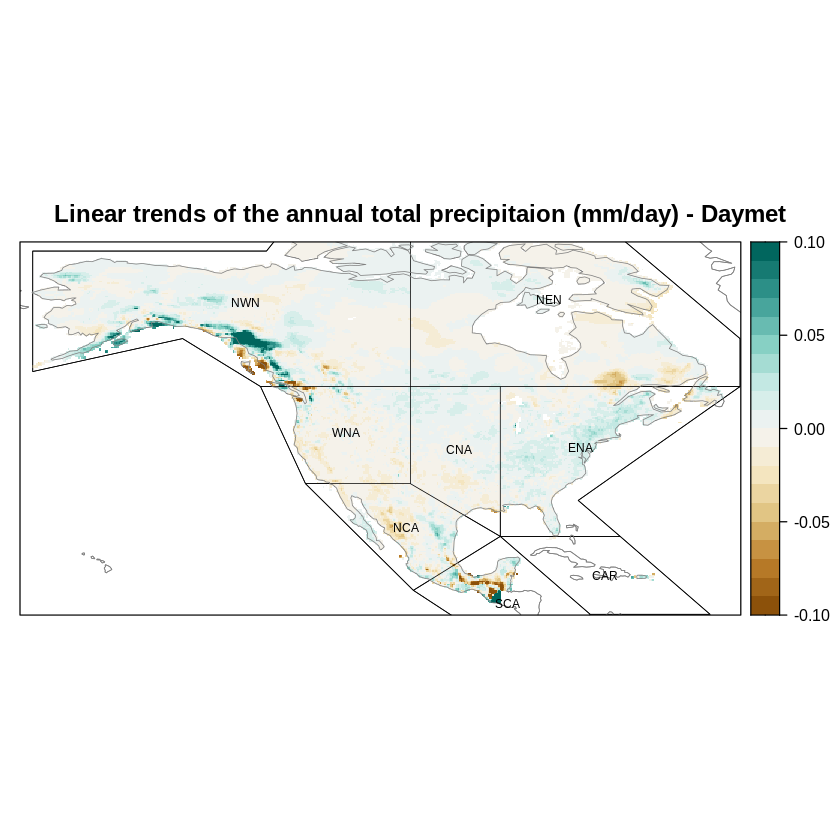

In [18]:
spatialPlot(regsGrid, 
            col.regions = brewer.pal(n = 9, "BrBG") %>% colorRampPalette(),
            at = colorScale_trends, 
            set.min = colorScale_trends[1],
            set.max = colorScale_trends[length(colorScale_trends)],
            main = paste("Linear trends of the annual total precipitaion (mm/day) - Daymet"),
            sp.layout = list(  
            list(regs[regs.area], first = FALSE, lwd = 0.6),
            list(coast, col = "gray50", first = FALSE, lwd = 0.6),  
            list("sp.text", coordinates(regs[regs.area]), names(regs[regs.area]), first = FALSE, cex = 0.6)
))

We repeat the process but to the obtain the p-values of the linear trends. Therefore we subset the variable `"pval"`using `subsetGrid`. Then we mask the p-values over the IPCC regions using function `overGrid`. But previously we build an artificial land-sea mask to avoid R misuses with NaN data over the sea when calculating the p-values.

In [19]:
mask <- binaryGrid(climatology(grid),condition = "GE", threshold = 0, values = c(NA,1))
pvalGrid <- linearTrend(grid, p = 0.9) %>% subsetGrid(var = "pval") %>% gridArithmetics(mask) 
pvalGrid <- overGrid(pvalGrid, regs[regs.area])

[2020-12-10 19:15:40] - Computing climatology...

[2020-12-10 19:15:42] - Done.

The slope of the linear trend is estimated based on the temporal resolution of the data. Please consider using the function aggregateGrid prior to the call of linearTrend to adequate the data to your resolution of interest.

[2020-12-10 19:15:43] - Computing climatology...

[2020-12-10 19:15:44] - Done.

Warning message:
“Only one grid passed as input. Nothing was done”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded datum WGS_1984 in CRS definition,
 but +towgs84= values preserved”


We use the p-values computed above to perform hatching over the future spatial maps. To do so, we capsulate the function `map.hatching` in a 2-way loop that corresponds to each line in a 'x' symbol. An 'x' would be associated whenever the condition is fullfilled, in our casem whenever the p-value is greater than 0.1. The `aggr.fun` indicates how to treat/aggregate the information contained in adjacent spatial gridpoints when upscaling is done.

In [22]:
aggr.fun <- function(x) {
    xx <- length(which(!is.na(x)))/length(x) * 100
    if (as.numeric(xx >= 75)) 0 else NA
}
l <- lapply(c("45","-45"), FUN = function(z) {
    c(map.hatching(clim = climatology(pvalGrid), 
                   threshold = 0.1, 
                   condition = "GT", 
                   density = 6,
                   angle = z, coverage.percent = 50,
                   upscaling.aggr.fun = list(FUN = aggr.fun)), 
    "which" = 1, lwd = 0.6)
})

[2020-12-10 19:17:37] - Computing climatology...

[2020-12-10 19:17:39] - Done.

Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded datum WGS_1984 in CRS definition,
 but +towgs84= values preserved”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded datum WGS_1984 in CRS definition,
 but +towgs84= values preserved”
[2020-12-10 19:17:40] - Computing climatology...

[2020-12-10 19:17:41] - Done.

Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded datum WGS_1984 in CRS definition,
 but +towgs84= values preserved”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded datum WGS_1984 in CRS definition,
 but +towgs84= values preserved”


We rely on `spatialPlot` from visualizeR, to depict the trend maps and include the p-value as hatching as a member of the `sp.layout` list.

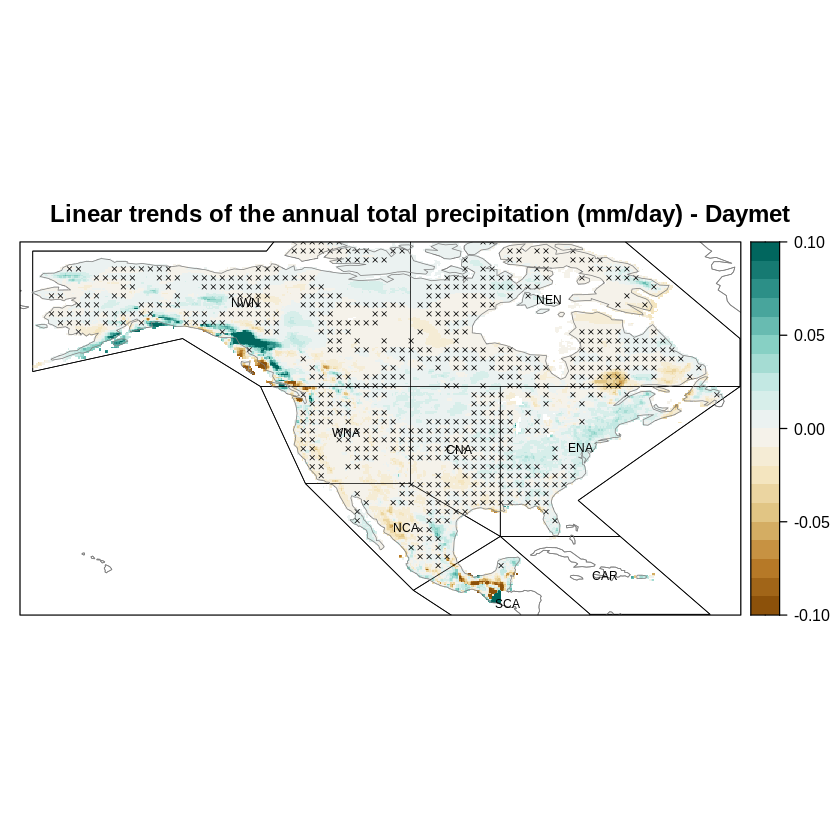

In [23]:
spatialPlot(regsGrid, 
            col.regions = brewer.pal(n = 9, "BrBG") %>% colorRampPalette(),
            at = colorScale_trends, 
            set.min = colorScale_trends[1],
            set.max = colorScale_trends[length(colorScale_trends)],
            main = paste("Linear trends of the annual total precipitation (mm/day) - Daymet"),
            sp.layout = list(
            l[[1]],l[[2]],  
            list(regs[regs.area], first = FALSE, lwd = 0.6),
            list(coast, col = "gray50", first = FALSE, lwd = 0.6),  
            list("sp.text", coordinates(regs[regs.area]), names(regs[regs.area]), first = FALSE, cex = 0.6)
))